# 8. 트랜스포머로 만드는 대화형 챗봇 프로젝트

In [1]:
import tensorflow

print(tensorflow.__version__)

2.6.0


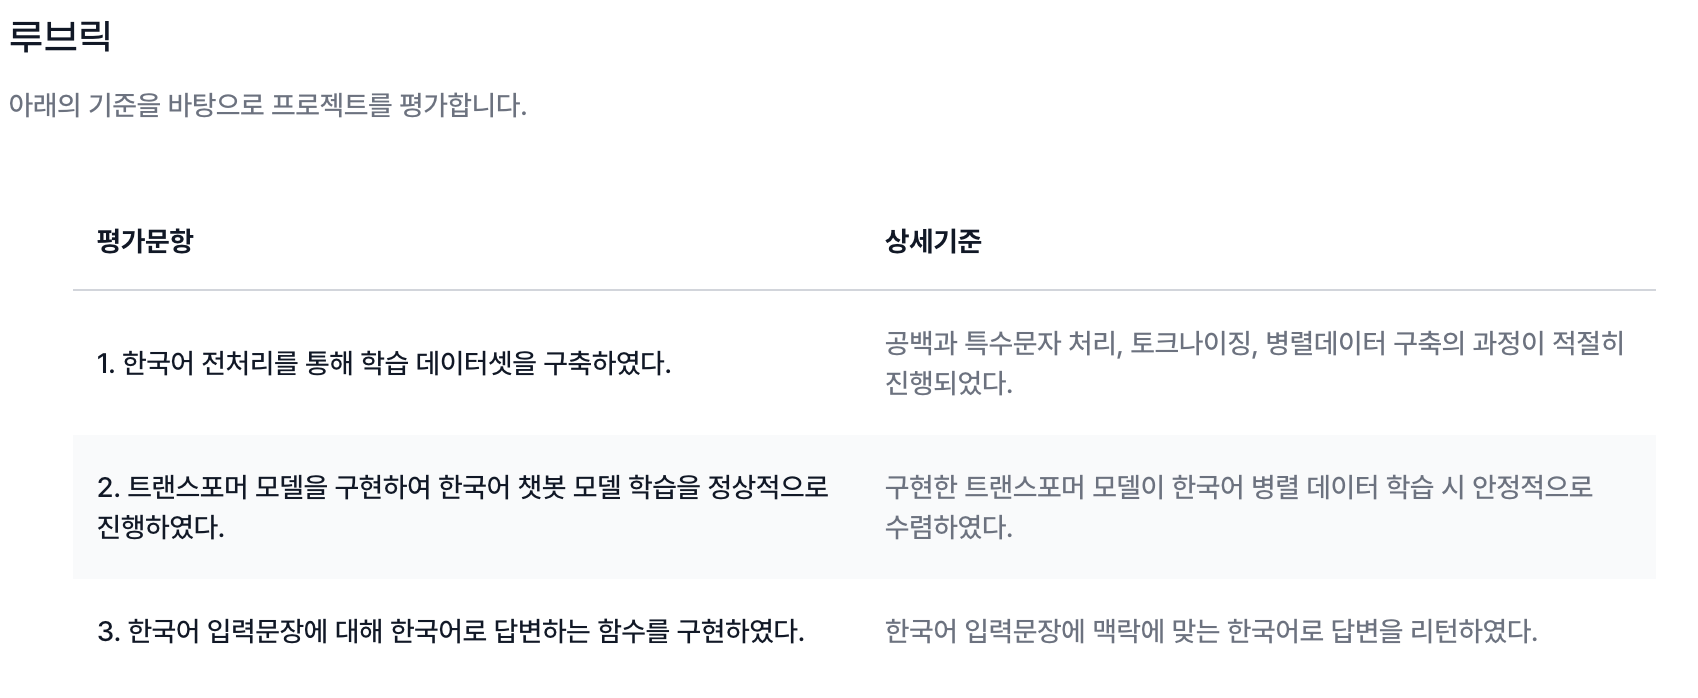

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt

## Step 1. 데이터 수집하기
- [챗봇데이터](https://github.com/songys/Chatbot_data/blob/master/ChatbotData.csv)
```
$ mkdir -p ~/aiffel/transformer_chatbot/data/
$ ln -s ~/data/* ~/aiffel/transformer_chatbot/data/
```


In [3]:
os.getenv("HOME")

'/aiffel'

In [4]:
data_dir = os.getenv("HOME") + "/data/ChatbotData .csv"

In [5]:
import pandas as pd
df = pd.read_csv(data_dir)

In [6]:
df

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


## Step 2. 데이터 전처리하기


In [7]:
# 전처리 함수
def preprocess_sentence(sentence):
  # 입력받은 sentence 양쪽 공백 제거
  sentence = sentence.strip()

  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  # 예를 들어서 "I am a student." => "I am a student ."와 같이
  # student와 온점 사이에 거리를 만듭니다.
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)

  # (a-z, A-Z, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체
  sentence = re.sub(r'[^a-zA-Z.?!,]+', ' ',sentence)
  sentence = sentence.strip()
  return sentence

#### 데이터프레임

In [86]:
df

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


In [14]:
# 질문, 답 데이터 전처리 및 나눠서 저장하기
questions = []
for sentence in df['Q']:
    # 구두점에 대해서 띄어쓰기
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    questions.append(sentence)

answers = []
for sentence in df['A']:
    # 구두점에 대해서 띄어쓰기
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    answers.append(sentence)

In [16]:
# 결과 확인
print(questions[:10])
print(answers[:10])

['12시 땡 !', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다', '3박4일 정도 놀러가고 싶다', 'PPL 심하네', 'SD카드 망가졌어', 'SD카드 안돼', 'SNS 맞팔 왜 안하지ㅠㅠ', 'SNS 시간낭비인 거 아는데 매일 하는 중', 'SNS 시간낭비인데 자꾸 보게됨']
['하루가 또 가네요 .', '위로해 드립니다 .', '여행은 언제나 좋죠 .', '여행은 언제나 좋죠 .', '눈살이 찌푸려지죠 .', '다시 새로 사는 게 마음 편해요 .', '다시 새로 사는 게 마음 편해요 .', '잘 모르고 있을 수도 있어요 .', '시간을 정하고 해보세요 .', '시간을 정하고 해보세요 .']


## Step 3. SubwordTextEncoder 사용하기
- 한국어 데이터는 형태소 분석기를 사용하여 토크나이징을 해야 한다고 많은 분이 알고 있습니다. 
- 하지만 여기서는 형태소 분석기가 아닌 위 실습에서 사용했던 내부 단어 토크나이저인 SubwordTextEncoder를 그대로 사용해보세요.



In [20]:
import tensorflow_datasets as tfds

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

- 이 부분에서 단순히 df로만 학습시켜 대화 쌍에 대한 학습을 제대로 못 시킴
- questions + answers로 바꾸어 학습 

In [21]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [22]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8178]
END_TOKEN의 번호 : [8179]


In [23]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8180


In [24]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(df["Q"][22])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(df["A"][22])))

정수 인코딩 후의 21번째 질문 샘플: [389, 811, 40, 413, 7985]
정수 인코딩 후의 21번째 답변 샘플: [389, 811, 913, 6541, 7968, 7954, 5087, 7605, 1114, 7790, 350, 5599, 44, 7968]


In [25]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 20
print(MAX_LENGTH)

20


In [26]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs

In [27]:
questions, answers = tokenize_and_filter(df["Q"], df["A"])
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8180
필터링 후의 질문 샘플 개수: 11786
필터링 후의 답변 샘플 개수: 11786


3. 교사강요

In [28]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [29]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

In [30]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [31]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [32]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [33]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [34]:
# 위의 과정을 모두 담은 decoder_inference() 함수
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)

In [35]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [36]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

# 이 글에서 앞으로 어텐션을 수행한다고 한다면, 스케일드 닷 프로덕트 어텐션을 의미합니다!

In [37]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs

## Step 4. 모델 구성하기


In [38]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)


In [41]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 3 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3675392     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [42]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

In [43]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

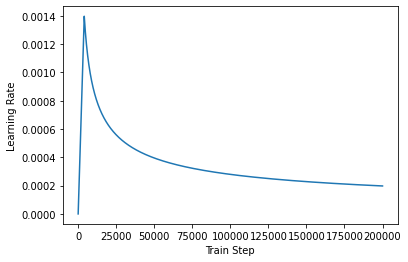

In [44]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## Step 5. 모델 평가하기


In [45]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [46]:
EPOCHS = 150
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/150
185/185 [==============================] - 19s 47ms/step - loss: 2.9416 - accuracy: 0.0453
Epoch 2/150
185/185 [==============================] - 9s 47ms/step - loss: 2.3895 - accuracy: 0.0993
Epoch 3/150
185/185 [==============================] - 9s 46ms/step - loss: 2.0485 - accuracy: 0.1049
Epoch 4/150
185/185 [==============================] - 9s 46ms/step - loss: 1.9076 - accuracy: 0.1117
Epoch 5/150
185/185 [==============================] - 9s 46ms/step - loss: 1.7995 - accuracy: 0.1179
Epoch 6/150
185/185 [==============================] - 8s 46ms/step - loss: 1.6880 - accuracy: 0.1252
Epoch 7/150
185/185 [==============================] - 9s 47ms/step - loss: 1.5626 - accuracy: 0.1356
Epoch 8/150
185/185 [==============================] - 9s 46ms/step - loss: 1.4249 - accuracy: 0.1494
Epoch 9/150
185/185 [==============================] - 9s 47ms/step - loss: 1.2776 - accuracy: 0.1653
Epoch 10/150
185/185 [==============================] - 9s 47ms/step - loss: 1.12

In [47]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

#   print('입력 : {}'.format(sentence))
#   print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence

### 1차 시도
- MAX_LEN = 40
- df 바로 활용하여 제대로 학습되지 않은 상태

In [57]:
sentence_generation('힘든 연애 좋은 연애라는게 무슨 차이일까?')

입력 : 힘든 연애 좋은 연애라는게 무슨 차이일까?
출력 : 괜찮은 사랑을 해보세요.


'괜찮은 사랑을 해보세요.'

In [58]:
sentence_generation('힘들어서 결혼할까봐')

입력 : 힘들어서 결혼할까봐
출력 : 자신을 사랑


'자신을 사랑'

In [59]:
sentence_generation('신고하고 싶어요?!')

입력 : 신고하고 싶어요?!
출력 : 연락을 하세요.


'연락을 하세요.'

- input을 넣어 바로바로 답변할 수 있도록 변경하여 여러 문장 출력

In [66]:
while True:
  input_sentence = input('입력 문장: ')
  if input_sentence == 'q':
    break
  
  output_sentence = sentence_generation(input_sentence)
#   print(f'입력: {input_sentence}')
  print(f'출력: {output_sentence}\n')

입력 문장: 누구세요
출력: 자신을 사랑

입력 문장: 나 이제 어떻게 해야할까요??
출력: 저는 자장면이요.

입력 문장: 오늘 날씨가 어떤 지 알려주세요
출력: 자신을 사랑

입력 문장: 당신은 누구신가요?
출력: 괜찮은 사랑을 해보세요.

입력 문장: 배가 고픈데 살을 빼야해서 밥을 먹어도 될까요?
출력: 괜찮은 사랑을 해보세요.

입력 문장: 중고거래 사기를 당해서 이거를 신고하고 싶어요!
출력: 사랑의 느낌이길 바랄게요.

입력 문장: 공부잘하는 방법 알려주세요.
출력: 네

입력 문장: 해물파전 만드는 방법 알려주세요.
출력: 네

입력 문장: 이름이 뭐예요.
출력: 네

입력 문장: 네 밖에 못 하나요.
출력: 네

입력 문장: 네라고 하지 마세요.
출력: 네

입력 문장: 네 라고 하지 마세요!
출력: 사랑의 느낌이길 바랄게요.

입력 문장: 집에 가세요!
출력: 사랑의 느낌이길 바랄게요.

입력 문장: 당신의 이름은 무엇입니까?
출력: 괜찮은 사랑을 해보세요.

입력 문장: 집으로 오세요?
출력: 괜찮은 사랑을 해보세요.

입력 문장: 그러면 이제부터 대답하지 마세요!!
출력: 성공을 기원합니다.

입력 문장: 포키포키 먹어보자!!
출력: 성공을 기원합니다.

입력 문장: 오늘은 총선투표일입니다. 안 그런가요?!
출력: 저는 도움이 없어요.

입력 문장: 무얼 하셨나요?!
출력: 연락을 하세요.

입력 문장: 할 수 있는 일이 뭔가요?!
출력: 연락을 하세요.

입력 문장: 불고기 파스타를 만드는 방법을 알고 있다고요?!
출력: 연락을 하세요.

입력 문장: 종이 만드는 방법을 알고 있으면 연락을 하겠다고요?!
출력: 연락을 하세요.

입력 문장: 좋습니다. 집에 간다고요?!
출력: 저는 도움이 없어요.

입력 문장: 웃기는 짬뽕이네..
출력: 또 다른 시작.

입력 문장: 또 다른 시작 같은 소리 하네..
출력: 또 다른 시작.

입력 문장: 문장부호를 보고 답을 하는거군요...
출력: 자신을 사랑해주세요.

입력 문장: 당신을 이제 다 파악

### 2차 시도
- MAX_LENGTH = 20
- Q, A 나누어 제대로 학습시킴
- batch size = 128, dropout = 0.2

In [48]:
while True:
  input_sentence = input('입력 문장: ')
  if input_sentence == 'q':
    break
  
  output_sentence = sentence_generation(input_sentence)
#   print(f'입력: {input_sentence}')
  print(f'출력: {output_sentence}\n')

입력 문장: 지그 보고 있는 드라마에 PPL이 너무 많아요.
출력: 눈살이 찌푸려지죠.

입력 문장: 여행하고 싶어요. 스페인으로. 지난 번에 정말 좋았거든요!
출력: 아직 받아들여지지 않아서 그런가봐요.

입력 문장: 현실을요?
출력: 실천이 말보다 낫죠.

입력 문장: 오늘 하루를 알차고 보람차게 보내려구요.
출력: 최근에 이별을 하셨나보군요.

입력 문장: 아니 이별을 하진 않았는데...
출력: 다른 일에 집중 해보는 건 어떨까요.

입력 문장: 어차피 공부밖에 안 해요.
출력: 최근에 이별을 하셨나보군요.

입력 문장: 아니 이별을 하지 않았다니까요?!
출력: 그래도 힘들죠.

입력 문장: 인생이 힘들긴 하죠.
출력: 최근에 이별을 하셨나보군요.

입력 문장: 계속 보고 싶으면 어떡하죠?
출력: 실천이 말보다 낫죠.

입력 문장: 보러 가라는 말이야?
출력: 실천이 말보다 낫죠.

입력 문장: 그러니까 실천하라는 뜻?
출력: 실천이 말보다 낫죠.

입력 문장: 결혼할까보다
출력: 많이 벌수록 좋아요.

입력 문장: 돈 많이 버는 방법을 알려줘.
출력: 최근에 이별을 하셨나보군요.

입력 문장: 공부를 꼭 해야 할까요.
출력: 최근에 이별을 하셨나보군요.

입력 문장: 금연이 쉽지 않아요.
출력: 최근에 이별을 하셨나보군요.

입력 문장: 가족 관계 알려줘.
출력: 최근에 이별을 하셨나보군요.

입력 문장: 갑자기 왜이래?
출력: 실천이 말보다 낫죠.

입력 문장: 아침에 들을 노래 추천해줘!
출력: 좋겠어요!

입력 문장: 운동 다녀왔어.
출력: 최근에 이별을 하셨나보군요.

입력 문장: 운동 다녀왔어
출력: 많이 벌수록 좋아요.

입력 문장: 심심한데 뭐 재미있는 거 없을까?
출력: 실천이 말보다 낫죠.

입력 문장: q


## 회고

#### 1. 실험 결과 해석

##### 첫 번째 실험 

   > 학습 데이터 형식: Direct formatting (Df), 문장부호 기반 답변 학습한 결과가 나옴 \
   > max_length: 40 \
   > 하이퍼파라미터: NUM_LAYERS = 4, EPOCHS = 200, D_MODEL = 512, NUM_HEADS = 16, UNITS = 2048, DROPOUT = 0.2
    
    1) 문장 부호에 따른 응답 패턴: 입력 문장의 종료 부호(예: ., ?, !)에 따라 챗봇이 패턴화된 응답을 하는 경향. 예를 들어, !로 끝나는 문장 : "성공을 기원합니다", "좀 더 편안하게 드세요.", "사랑의 느낌이길 바랄게요." 등 긍정적이거나 위안을 주는 메시지 응답 경향. 그러나 이러한 응답은 질문의 맥락과는 거의 관련이 없어 보임

    2) 특정 키워드에 대한 고정된 응답: "네"라는 응답은 여러 다른 입력에 대한 일관된 답변으로 나타나며, 이는 챗봇이 특정 키워드나 패턴을 인식했을 때 고정된 답변을 하는 것으로 추정. 그러나 이러한 응답은 질문의 내용을 반영하지 않는 것으로 보임.

    3) 제한된 응답 범위: 챗봇의 응답이 "자신을 사랑해주세요.", "괜찮은 사랑을 해보세요.", "성공을 기원합니다."와 같이 제한된 범위의 문장들로 구성
    
    
##### 두 번째 실험 

> 학습 데이터 형식: Q&A를 분리하여 학습 ⇢ 사전 개수 증가 \
> max_length: 20 \
> 하이퍼파라미터: NUM_LAYERS = 3, EPOCHS = 150, D_MODEL = 256, NUM_HEADS = 8, UNITS = 512, DROPOUT = 0.1
    
    1) 반복되는 특정 답변: 특정 질문이나 주제에 대해 비슷한 또는 동일한 답변 반복 제공 경향. 예를 들어, "최근에 이별을 하셨나보군요."라는 응답이 여러 상황에서 반복적으로 사용. 이는 시스템이 특정 키워드나 문맥에 대해 고정된 반응을 가지고 있음을 시사

    2) 학습되지 않은 데이터에 대한 반응성 낮음

    3) 응답의 일관성 부족: 같은 또는 매우 유사한 입력에 대해 서로 다른 답변을 제공하는 경우. 이는 시스템이 일관된 기준 없이 응답을 생성하고 있음. 예를 들어, "운동 다녀왔어"에 대한 응답이 "최근에 이별을 하셨나보군요."에서 "많이 벌수록 좋아요."로 변경됨

    4) 특정 문맥에 대한 고정된 반응: 일부 질문이나 상황에 대해 특정 반응 고정적으로 제공하는 경향. 예를 들어, "실천이 말보다 낫죠."라는 답변이 다양한 문맥에서 반복적으로 사용. 이는 시스템이 특정 키워드나 문구에 고정된 응답을 갖고 있음을 시사

두 번째 실험을 통해 성능 개선의 긍정적인 방향성을 확인할 수 있었다.. `max_length`의 축소와 Q&A를 분리하여 학습하는 접근은 모델의 응답 다양성과 효율성을 높이는 데 기여했다. 이러한 변화는 짧고 직접적인 대화 형식에 있어 모델의 반응성을 개선하는 효과를 가져왔다.

#### 배운 점

- **데이터 전처리의 중요성**: Q&A 분리 학습 방법
- **`max_length` 설정 영향**: 응답의 길이에 대한 조절이 모델의 성능에 미치는 영향. 짧은 길이 설정은 응답의 직접성을 높이는 반면, 너무 짧게 설정하면 복잡한 질문에 대한 충분한 답변을 제공하기 어렵다.

#### 개선할 점

- **문맥 이해력 강화**: 모델의 문맥 이해력을 더욱 강화하기 위해, 긴 대화의 맥락을 파악할 수 있는 데이터 전처리 기법이나 모델 구조의 개선이 필요하다.
- **하이퍼파라미터 최적화**
